In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

### Request HPC Resources

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

ds = xr.open_dataset(
        savedir + "Southern_Ocean_WMT_Budget.nc")

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

### Extract time-mean mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\leq + \mathcal{S}_\leq + \Psi_\leq + \mathcal{G}^{BF}_\leq + \mathcal{G}^{Mix}_\leq + \mathcal{G}^{Spurious}_\leq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\leq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\leq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\leq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\leq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\leq$.
- $\mathcal{G}^{BF}_\leq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\leq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\leq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


### Checking the total budget

-0.021266947681987194
-0.03073840142872148
0.009471453746734287
-0.04093786332121658
-0.0055157389508178
-0.03542212437039878
-0.01779954855814277
-0.0012947106127338308
-0.01650483794540894


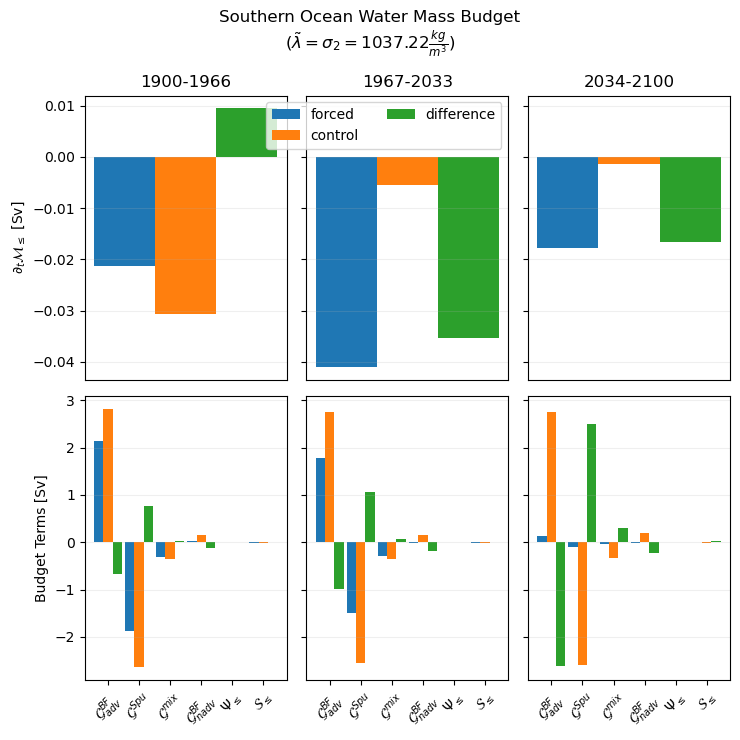

In [72]:
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'BF_Adv',
           'spurious_numerical_mixing',
           'diffusion', 
           'BF_NonAdv',
           'convergent_mass_transport', 
           'mass_source', 
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_{\leq}$", 
                  r"$\mathcal{G}^{BF}_{adv}$",
                  r"$\mathcal{G}^{Spu}$",
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{BF}_{nadv}$",
                  r"$\Psi_{\leq}$", 
                  r"$\mathcal{S}_{\leq}$", 
                  ]



fig, ax = plt.subplots(2, 3, figsize = (7.5, 7.5),sharey = "row")
[a.grid(alpha = 0.2, axis = "y") for a in ax.flatten()]
width = 0.3

times = [("1900", "1966"), ("1967", "2033"), ("2034", "2100")]
for (it, t) in enumerate(times):
    wmt_mean = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    difference = -wmt_mean.diff(dim = "exp")
    difference.coords['exp'] = ["difference"]
    wmt_mean = xr.merge([wmt_mean, difference])
    curr_width = 0.0
    ax[0, it].set_title('-'.join(t))
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)
        print(wmt_mean_budget['mass_tendency'].values)
        bvalues = [wmt_mean_budget[k].values for k in budgets]
    
        ax[0, it].bar(0 + curr_width, bvalues[0], label = exp, width = width)
    
        nterms = np.arange(len(budgets_labels[1:]))
    
        ax[1, it].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
        curr_width += width
    
# [a.legend() for a in ax.flatten()]
[a.set_xticks([]) for a in ax[0, :]];
ax[0, 0].set_ylabel(budgets_labels[0] + " [Sv]")
ax[1, 0].set_ylabel("Budget Terms [Sv]")

[a.set_xticks(np.arange(len(budgets_labels[1:])) + width, budgets_labels[1:], rotation = 45) for a in ax[1, :]];
fig.suptitle("Southern Ocean Water Mass Budget\n" + r"$(\tilde \lambda = \sigma_2 = 1037.22 \frac{kg}{m^3})$")
fig.tight_layout()
ax[0, 1].legend(ncols = 2)

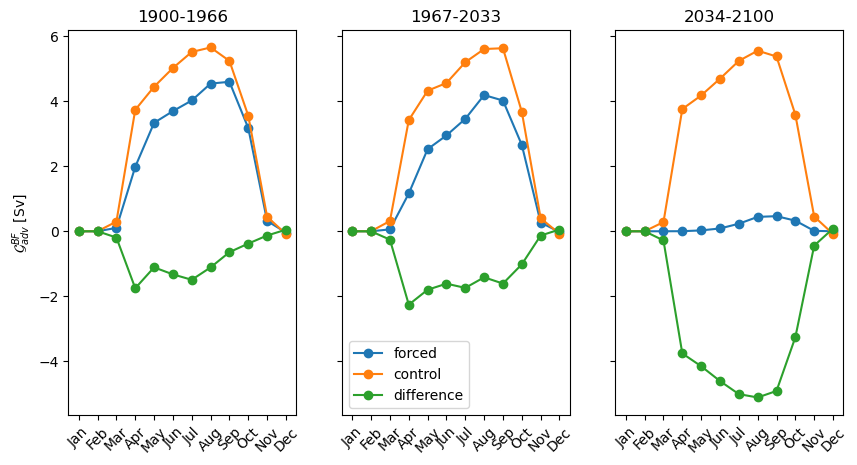

In [51]:
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

fig, ax = plt.subplots(1, 3, figsize = (10, 5), sharey = "row")

width = 0.25
times = [("1900", "1966"), ("1967", "2033"), ("2034", "2100")]

for (it, t) in enumerate(times):
    wmt_mean = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).groupby("time.month").mean("time")
    difference = -wmt_mean.diff(dim = "exp")
    difference.coords['exp'] = ["difference"]
    wmt_mean = xr.merge([wmt_mean, difference])
    ax[it].set_title('-'.join(t))
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)["surface_ocean_flux_advective_negative_rhs"]
    
        ax[it].plot(wmt_mean_budget.month, wmt_mean_budget, marker = "o", label = exp)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax[0].set_ylabel(r"$\mathcal{G}^{BF}_{adv}$" + " [Sv]")
ax[1].legend()
[a.set_xticks(wmt_mean_budget.month, months, rotation = 45) for a in ax];


In [81]:
tendencies = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1900", None))

Text(0.5, 0.98, 'Southern Ocean Mass Budget Terms')

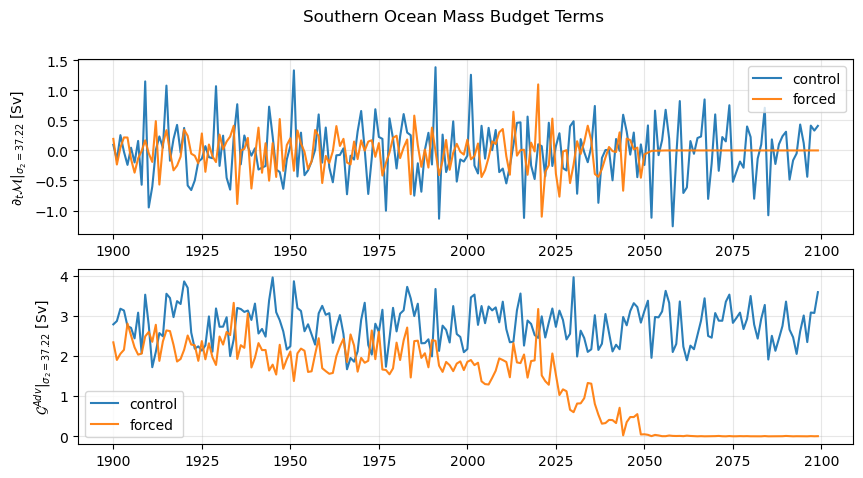

In [90]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5))
[a.grid(alpha = 0.3) for a in ax]
ax[0].plot(tendencies.year, tendencies["mass_tendency"].isel(exp = 1), label = "control", linewidth = 1.5, alpha = 0.95)
ax[0].plot(tendencies.year, tendencies["mass_tendency"].isel(exp = 0), label = "forced", linewidth = 1.5, alpha = 0.95)
ax[0].legend()

ax[1].plot(tendencies.year, tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 1), label = "control", linewidth = 1.5, alpha = 0.95)
ax[1].plot(tendencies.year, tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0), label = "forced", linewidth = 1.5, alpha = 0.95)

ax[1].legend()

ax[0].set_ylabel(r"$\partial_{t} \mathcal{M}|_{\sigma_2 = 37.22}$" + " [Sv]")
ax[1].set_ylabel(r"$\mathcal{G}^{Adv}|_{\sigma_2 = 37.22}$" + " [Sv]")

fig.suptitle("Southern Ocean Mass Budget Terms")